In [18]:
"""
Census similarity graph:
  • Each row = node
  • Edge weight = # of matching categorical attributes
  • Louvain communities + optional visualisation
  • Conversion to PyTorch Geometric
"""

# 0) ────────────────────────────────────────────────────────────────────────────
import os, math, itertools, collections, json
import pandas as pd
import networkx as nx

# Optional libs (install if needed)
try:
    import matplotlib.pyplot as plt
    HAVE_PLOT = True
except ImportError:
    HAVE_PLOT = False

try:
    from torch_geometric.utils import from_networkx
    HAVE_PYG = True
except ImportError:
    HAVE_PYG = False


In [19]:


# 1) Load data ─────────────────────────────────────────────────────────────────
CSV_PATH = "sample.csv"           # adjust if needed
df = pd.read_csv(CSV_PATH)

target_col = "income bracket"     # keep as node attribute
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]


In [20]:
# 2) Build graph ───────────────────────────────────────────────────────────────
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx,
               **{c: row[c] for c in cat_cols},
               **{f"{c}_num": row[c] for c in num_cols},
               target = 0 if row[target_col].strip() == "- 50000." else 1)

# Add weighted edges
for i, j in itertools.combinations(df.index, 2):
    w = sum(df.loc[i, c] == df.loc[j, c] for c in cat_cols)
    if w:
        G.add_edge(i, j, weight=w)

print(f"Nodes: {G.number_of_nodes():,}")
print(f"Edges: {G.number_of_edges():,}")

KeyboardInterrupt: 

In [4]:
# 3) Prune weak edges to reduce density (optional) ─────────────────────────────
THRESH = 15        # keep edges with ≥15 shared cats (tweak!)
G_pruned = nx.Graph(((u, v, d) for u, v, d in G.edges(data=True)
                     if d['weight'] >= THRESH))
print(f"After pruning (≥{THRESH}): edges → {G_pruned.number_of_edges():,}")



After pruning (≥15): edges → 727


In [5]:
# 4) Community detection (Louvain) ─────────────────────────────────────────────
try:
    from networkx.algorithms.community import louvain_communities
except ImportError:
    raise ImportError("networkx>=3.2 required for built‑in Louvain algorithm")

communities = louvain_communities(G_pruned, weight="weight", seed=42)
print(f"Detected {len(communities)} communities\n")
for cid, comm in enumerate(communities):
    hi_pct = 100 * sum(G.nodes[n]['target'] for n in comm) / len(comm)
    print(f" • Community {cid:2d}  | size={len(comm):2d}  | %>50K= {hi_pct:4.1f}%")


Detected 3 communities

 • Community  0  | size=20  | %>50K=  0.0%
 • Community  1  | size=11  | %>50K=  0.0%
 • Community  2  | size=19  | %>50K=  0.0%


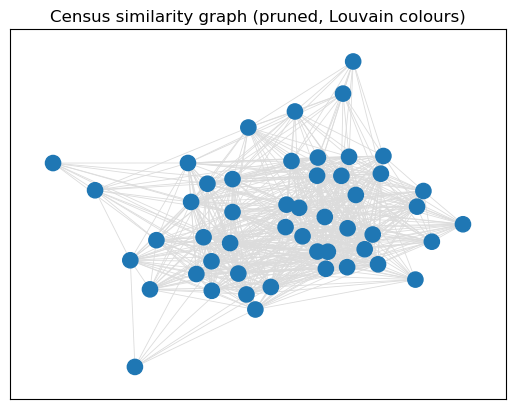

In [6]:
# 5) Visualise small graphs (<200 nodes) ───────────────────────────────────────
if HAVE_PLOT and G_pruned.number_of_nodes() <= 200:
    pos = nx.spring_layout(G_pruned, seed=1, weight="weight")
    colors = ['tab:blue' if G.nodes[n]['target']==0 else 'tab:orange'
              for n in G_pruned.nodes]
    nx.draw_networkx(G_pruned, pos,
                     node_size=120, node_color=colors,
                     edge_color='gainsboro', width=0.6,
                     with_labels=False)
    plt.title("Census similarity graph (pruned, Louvain colours)")
    plt.show()


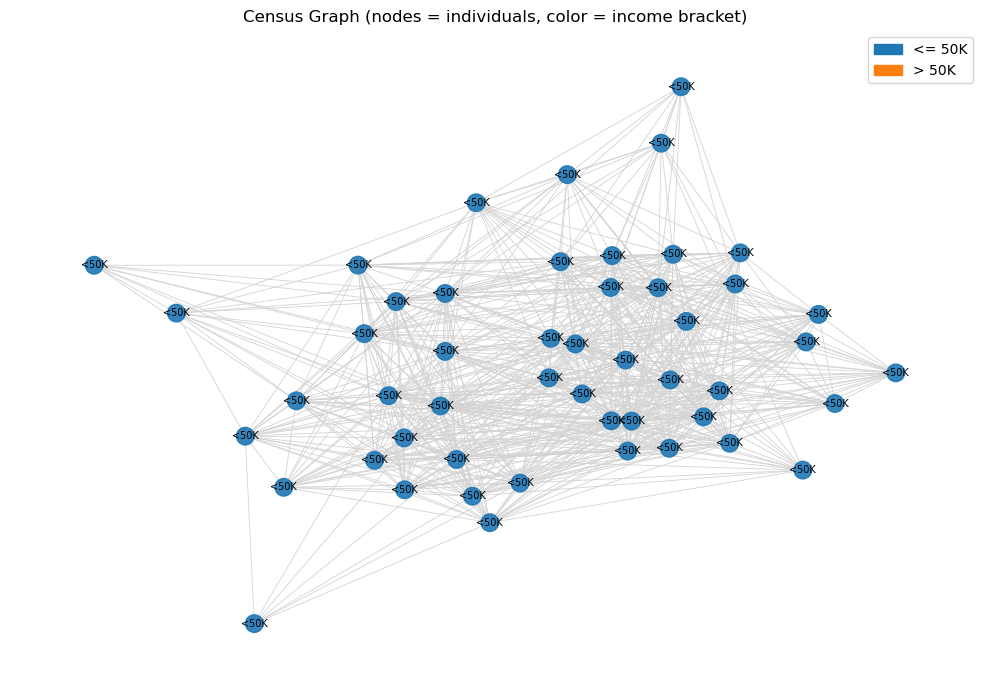

In [8]:
# 5) Visualise small graphs (<200 nodes) ───────────────────────────────────────
if HAVE_PLOT and G_pruned.number_of_nodes() <= 200:
    pos = nx.spring_layout(G_pruned, seed=1, weight="weight")

    # Assign colors: blue for "<=50K", orange for ">50K"
    node_colors = [
        'tab:blue' if G.nodes[n]['target'] == 0 else 'tab:orange'
        for n in G_pruned.nodes
    ]

    labels = {
        n: "<50K" if G.nodes[n]['target'] == 0 else ">50K"
        for n in G_pruned.nodes
    }

    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(G_pruned, pos,
                           node_color=node_colors,
                           node_size=160, alpha=0.9)
    nx.draw_networkx_edges(G_pruned, pos, edge_color='lightgray', width=0.6)
    nx.draw_networkx_labels(G_pruned, pos, labels=labels, font_size=7)

    # Legend
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(color='tab:blue', label='<= 50K'),
        Patch(color='tab:orange', label='> 50K')
    ]
    plt.legend(handles=legend_handles, loc="best", frameon=True)
    plt.title("Census Graph (nodes = individuals, color = income bracket)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
# 6) Convert to PyTorch Geometric Data (optional) ──────────────────────────────
if HAVE_PYG:
    # Encode target as y
    for n in G.nodes:
        G.nodes[n]['y'] = G.nodes[n].pop('target')

    # Edge weights → "edge_weight"
    for u, v, d in G.edges(data=True):
        d['edge_weight'] = float(d['weight'])
        del d['weight']

    data = from_networkx(G)            # pyg Data object
    print("\nPyG Data:", data)
    print("x.shape:", data.x.shape, "| edge_index.shape:", data.edge_index.shape)
    # Now ready for torch_geometric.nn models


In [ ]:
print('here')